In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config, sys_params
from BondingCurveNexus.param_functions import wnxm_movement_per_eth
from BondingCurveNexus.uni_pool_markets import UniPoolMarkets
from scipy.stats import lognorm
from tqdm import tqdm
from random import shuffle

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1532.02

In [3]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2367963.19399908

In [4]:
system_instance = UniPoolMarkets()

In [5]:
print(sys_params.wnxm_price_now, system_instance.book_value(),
      f'{100 * sys_params.wnxm_price_now / system_instance.book_value()}%')

0.01282751 0.021568760834787554 59.47263312091126%


In [6]:
system_instance.book_value()*eth_price_usd

33.04377297411123

# Dutch Auction Modelling

## Dutch Auction Mechanism

Assume that we start at wNXM, as new tokenomics will start slightly below; therefore the first "interesting point" will be when we hit wNXM price.

Mechanism is a Uniswap v2 Curve to push price up when buys happen & down when sales happen.

Exploring main option:
- One-sided markets above and below book with price discovery through a ratchet mechanism.
- Here, buys are disabled below book and sells are disabled above book in order to completely avoid book value dilution from users.
- Mutual benefits mainly from rising price and positive sentiment
- Soft anchoring to Book Value

### Liquidity parameters

Current proposed approach to liquidity: 
- have a large opening liquidity that allows us to get to book value while draining wNXM markets (tens of thousands of ETH)
- have a low target liquidity (<5k ETH) that liquidity approaches over time
- increase liquidity towards target below BV and decrease liquidity above BV towards target, but not the other way around

In [7]:
# opening liquidity provided
opening_liq = 25_000
# target liquidity
liq_target = 2500
# percentage of target per day that liquidity moves (additively) towards target
liq_move_perc = 0.04
# number of daily liquidity moves
liq_moves_per_day = 10

### Ratchet sizing

Ratchet speed, for consistency, should be defined in relation to book value price. This enables a linear climb/descent towards book value instead of a percentage or fixed number of NXM liquidity.

Also defining how many times this happens per day so that the ascent can be a bit smoother in the modelling. In practice, hopefully the ratchet is streamed.

Process inside system class:
- Define percentage x% of book value that increases on a daily basis as system parameter
- Use current book value to define x% in NXM price terms
- Solve for new NXM liquidity

In [8]:
ratchet_bv_perc = 0.04
ratchets_per_day = 10

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two. Rounded to nearest 10k (last 10/11/2022)

Latest is 131k, typical in current price range is about 250k-300k, but typically using 500k which assumes that liquidity is higher at higher prices. Crude, to be improved.

Function converts 2%-move USD liquidity to an absolute ETH value move per 1 ETH sold/bought on open market. This ETH value only depends on current wNXM price and not on the wNXM price at the time.

In [9]:
wnxm_move_size = wnxm_movement_per_eth(two_perc_liq_usd=500_000)
# fixed per-ETH move size based on 500,000 USD moving the price by 2% when price is 0.01 ETH
fixed_wnxm_move_size = 5e-07

In [10]:
# How a wNXM buy works:
# establish current price
wnxm_open_price = sys_params.wnxm_price_now
# establish number of wNXM bought
n_wnxm = 50000
# translate amount to ETH
n_eth = n_wnxm * wnxm_open_price
# establish closing price
wnxm_close_price = wnxm_open_price + n_eth * wnxm_movement_per_eth(500_000)
print(wnxm_open_price, n_eth, wnxm_close_price, wnxm_close_price/wnxm_open_price - 1)

0.01282751 641.3755 0.013331712119122322 0.039306312692199974


### NXM buy/sell sizing - Lognormal

lognormal distribution of size of a typical entry and exit in ETH

parameterised to median value being ~1 ETH, upper quartile ~3 ETH

In [11]:
entry_shape = 1.7
entry_loc = 0
entry_scale = 1

exit_shape = 1.7
exit_loc = 0
exit_scale = 1

In [12]:
pd.DataFrame(lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale, size=100_000)).describe()

,0
count,100000.000000
mean,4.188532
std,15.670839
min,0.000552
25%,0.315244
50%,0.994389
75%,3.101500
max,1267.765106


### NXM buy/sell sizing - Deterministic

To be able to properly assess the differences between individual runs, we may want to have deterministic buy & sell pressure within and outside the platform.

Size is mean of lognormal, so about 4.3 ETH.

In [13]:
det_sell_size = 4.3

### NXM buys/sells from platform per day

Poisson distribution of number of entries & exits per day.

Lambda parameters can also be used as deterministic numbers for runs.

In [14]:
lambda_entries = 100
lambda_exits = 100

In [15]:
pd.DataFrame(np.random.poisson(lam=lambda_entries, size=10_000)).describe()

,0
count,10000.000000
mean,99.908700
std,10.113634
min,64.000000
25%,93.000000
50%,100.000000
75%,107.000000
max,140.000000


### wNXM drift & diffusion

Relative % change in wNXM price on open market due to random fluctuations based on a normal distribution

In [16]:
wnxm_shifts_per_day = 1
wnxm_drift = (1+0.000)**(1/wnxm_shifts_per_day) - 1
wnxm_diffusion = (1+0.02)**(1/wnxm_shifts_per_day) - 1

In [17]:
print(wnxm_drift, wnxm_diffusion)

0.0 0.020000000000000018


## Uniswap v2 OOP Classes

1. UniPool - Base class with separate opening and target liquidities & movement towards target


2. UniOneStoch - subclass of 1. that runs stochastically
3. UniOneDet - subclass of 1. that runs deterministically

### UniPool Base Class

In [18]:
# Create class with specified initial liquidity & target liquidity

class UniPool:
    # initial parameters
    def __init__(self, open_liq, target_liq):
        # start at day 0
        self.current_day = 0
        
        # set wNXM and NXM supply, Capital Pool
        self.nxm_supply = system_instance.nxm_supply
        self.wnxm_supply = wnxm_supply_now
        self.cap_pool = system_instance.cap_pool
        
        # set initial wNXM price
        self.wnxm_price = wnxm_open_price     
        # set initial ETH liquidity
        self.liquidity_eth = open_liq
        # set target liquidity
        self.target_liq = target_liq
        
        # set change in wnxm price per 1 ETH of wnxm bought/sold
        self.wnxm_move_size = wnxm_move_size
        
        # set initial NXM liquidity based on opening wNXM price
        # assume that prices have converged after initial period
        self.liquidity_nxm = self.liquidity_eth / self.wnxm_price
        
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
        # base entries and exits - set stochasically or deterministically in subclasses
        self.base_daily_platform_buys = np.zeros(shape=model_days, dtype=int)
        self.base_daily_platform_sales = np.zeros(shape=model_days, dtype=int)
        
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.eth_acquired = 0
        self.nxm_burned = 0
        self.nxm_minted = 0
        self.wnxm_removed = 0
        self.wnxm_created = 0
        
        # set tracking lists for individual instance
        self.cap_pool_prediction = [self.cap_pool]
        self.nxm_price_prediction = [self.nxm_price()]
        self.wnxm_price_prediction = [self.wnxm_price]
        self.nxm_supply_prediction = [self.nxm_supply]
        self.wnxm_supply_prediction = [self.wnxm_supply]
        self.book_value_prediction = [self.book_value()]
        self.liquidity_nxm_prediction = [self.liquidity_nxm]
        self.liquidity_eth_prediction = [self.liquidity_eth]
        self.eth_sold_prediction = [self.eth_sold]
        self.eth_acquired_prediction = [self.eth_acquired]
        self.nxm_burned_prediction = [self.nxm_burned]
        self.nxm_minted_prediction = [self.nxm_minted]
        self.wnxm_removed_prediction = [self.wnxm_removed]
        self.wnxm_created_prediction = [self.wnxm_created]
        
        
    # book value expressed in ETH
    def book_value(self):
        if self.nxm_supply == 0:
            return 0
        return self.cap_pool/self.nxm_supply
    
    # system nxm price expressed in ETH
    def nxm_price(self):
        # return current nxm system price 
        return self.liquidity_eth / self.liquidity_nxm
    
    def nxm_sale_size(self):
        # defined in stoch v det subclasses - can be stochastic or deterministic 
        return 0
        
    # one sale of n_nxm NXM
    def platform_nxm_sale(self, n_nxm):
        
        # sells disabled above book, so above book user would sell wNXM on open market instead
        if round(self.nxm_price(), 4) > round(self.book_value(), 4):
            self.wnxm_market_sell(n_wnxm=n_nxm, create=True)
        
        else:
            # limit number to total NXM
            n_nxm = min(n_nxm, self.nxm_supply)

            # add sold NXM to pool
            self.liquidity_nxm += n_nxm
            self.nxm_supply -= n_nxm

            # establish new value of eth in pool
            new_eth = self.invariant / self.liquidity_nxm
            delta_eth = self.liquidity_eth - new_eth

            # add ETH removed and nxm burned to cumulative total, update capital pool
            self.eth_sold += delta_eth
            self.cap_pool -= delta_eth
            self.nxm_burned += n_nxm

            # update ETH liquidity & invariant
            self.liquidity_eth = new_eth
            self.invariant = self.liquidity_eth * self.liquidity_nxm
        
    # one buy of n_nxm NXM
    def platform_nxm_buy(self, n_nxm):
        
        # buys disabled below book, so user would buy wNXM on open market instead
        if round(self.nxm_price(), 4) < round(self.book_value(), 4):
            self.wnxm_market_buy(n_wnxm=n_nxm, remove=True)
        
        else:
            # limit number of single buy to 50% of NXM liquidity to avoid silly results
            n_nxm = min(n_nxm, 0.5 * self.liquidity_nxm)

            # remove bought NXM from pool and add actual mint to supply
            self.liquidity_nxm -= n_nxm
            self.nxm_supply += n_nxm

            # establish new value of eth in pool
            new_eth = self.invariant / self.liquidity_nxm
            delta_eth = new_eth - self.liquidity_eth

            # add ETH acquired and nxm minted to cumulative total, update capital pool
            self.eth_acquired += delta_eth
            self.cap_pool += delta_eth
            self.nxm_minted += n_nxm

            # update ETH liquidity
            self.liquidity_eth = new_eth
    
    def wnxm_market_buy(self, n_wnxm, remove=True):
        # limit number of wnxm bought to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole buy happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # increase price depending on defined liquidity parameters
        self.wnxm_price += n_eth * self.wnxm_move_size
        
        # if used for arb, remove from supply
        if remove:
            self.wnxm_supply -= n_wnxm
            self.wnxm_removed += n_wnxm
    
    def wnxm_market_sell(self, n_wnxm, create=True):
        # limit number of wnxm sold to total supply unless new wnxm is created
        if not create:
            n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount (assuming whole sell happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # decrease price depending on defined liquidity parameters
        self.wnxm_price -= n_eth * self.wnxm_move_size
        
        # if used for arb, add to supply
        if create:
            self.wnxm_supply += n_wnxm
            self.wnxm_created += n_wnxm
    
    def arb_sale_transaction(self):
        # establish size of nxm sell, limit to number of nxm supply and wnxm supply
        num = min(self.nxm_sale_size(), self.wnxm_supply, self.nxm_supply)
        # buy from open market
        self.wnxm_market_buy(n_wnxm=num, remove=True)
        # sell to platform
        self.platform_nxm_sale(n_nxm=num)
        
    def arb_buy_transaction(self):
        # establish size of nxm buy, limit to 50% of nxm liquidity in virtual pool to avoid spikes
        num = min(self.nxm_sale_size(), self.liquidity_nxm * 0.5)
        # buy from platform
        self.platform_nxm_buy(n_nxm=num)
        # sell to open market
        self.wnxm_market_sell(n_wnxm=num, create=True)
    
    def ratchet_down(self): 
        # establish price movement required to be relevant percentage of BV
        price_movement = self.book_value() * ratchet_bv_perc / ratchets_per_day
        
        # establish target price and cap at book value
        target_price = max(self.nxm_price() - price_movement, self.book_value())
        
        # update NXM liquidity to reflect new price
        self.liquidity_nxm = self.liquidity_eth / target_price
        
        # update invariant
        self.invariant = self.liquidity_eth * self.liquidity_nxm

    def ratchet_up(self): 
        # establish price movement required to be relevant percentage of BV
        price_movement = self.book_value() * ratchet_bv_perc / ratchets_per_day
        
        # establish target price and cap at book value
        target_price = min(self.nxm_price() + price_movement, self.book_value())
        
        # update NXM liquidity to reflect new price
        self.liquidity_nxm = self.liquidity_eth / target_price
        
        # update invariant
        self.invariant = self.liquidity_eth * self.liquidity_nxm        

    def liq_move(self, new_liq):
        # solve for required NXM liquidity first from current NXM price
        self.liquidity_nxm = new_liq / self.nxm_price()
        
        # update ETH liquidity
        self.liquidity_eth = new_liq
        
        # update invariant
        self.invariant = self.liquidity_nxm * self.liquidity_eth
        
    def new_liq(self, kind):
        # move ETH liquidity towards target
        
        # downward move
        if kind == 'down':
            # don't move if below book
            if self.nxm_price() < self.book_value():
                return self.liquidity_eth
            
        # if above book & above target liq, down to target at daily percentage rate (limit at target)
        # divided by number of times we're moving liquidity per day 
            return max(self.liquidity_eth - self.target_liq * liq_move_perc / liq_moves_per_day, self.target_liq)
        
        # if below target liq, up to target at daily percentage rate (limit at target)
        # divided by number of times we're moving liquidity per day        
        if kind == 'up':
            return min(self.liquidity_eth + self.target_liq * liq_move_perc / liq_moves_per_day, self.target_liq)

    def wnxm_shift(self):
        # defined in subclasses - can be stochastic or deterministic 
        self.wnxm_price *= 1
        
    def arbitrage(self):
        # in one-sided market class, also disable sells above BV and buys below BV
        
        # system price > wnxm_price arb
                # disable sales below book
                # platform sale price has to be higher than wnxm price for arbitrage
                # nxm supply has to be greater than zero
        while  self.nxm_price() <= self.book_value() and \
        self.nxm_price() > self.wnxm_price and \
        self.nxm_supply > 0 and self.wnxm_supply > 0:
            self.arb_sale_transaction()
            
        # system price < wnxm_price arb
                # buys disabled below book
                # platform price has to be lower than wnxm price for arbitrage
        while self.nxm_price() >= self.book_value() and \
        self.nxm_price() < self.wnxm_price and \
        self.nxm_supply > 0:
            self.arb_buy_transaction()

    def one_day_passes(self):
        # create list of events and shuffle it
        events_today = []
        events_today.extend(['ratchet'] * ratchets_per_day)
        events_today.extend(['liq_move'] * liq_moves_per_day)
        events_today.extend(['wnxm_shift'] * wnxm_shifts_per_day)
        events_today.extend(['platform_buy'] * self.base_daily_platform_buys[self.current_day])
        events_today.extend(['platform_sale'] * self.base_daily_platform_sales[self.current_day])
        shuffle(events_today)
        
        # LOOP THROUGH EVENTS OF DAY
        for event in events_today:
           # optional daily printouts, select current day
            if self.current_day == 365:
                print(f'''Day 365 - {event} - pre arbitrage: nxm_price = {self.nxm_price()}, wnxm_price = {self.wnxm_price}
                                            book_value = {self.book_value()}, cap_pool = {self.cap_pool},
                                            nxm_supply = {self.nxm_supply}, wnxm_supply = {self.wnxm_supply}
                ''')
            
            #-----WNXM ARBITRAGE-----#
            # happens in between all events
            self.arbitrage()

           # optional daily printouts, select current day
            if self.current_day == 365:
                print(f'''Day 365 - {event} - pre event: nxm_price = {self.nxm_price()}, wnxm_price = {self.wnxm_price}
                                            book_value = {self.book_value()}, cap_pool = {self.cap_pool},
                                            nxm_supply = {self.nxm_supply}, wnxm_supply = {self.wnxm_supply}
                ''')

            #-----RATCHET-----#
            if event == 'ratchet':
                # up if below BV
                if self.book_value() > self.nxm_price():
                    self.ratchet_up()
                # down if above BV (but ratchet_down method only enabled in one-sided subclass)
                if self.book_value() < self.nxm_price():
                    self.ratchet_down()

            #-----LIQUIDITY MOVE-----#
            if event == 'liq_move':
                # liquidity down towards target if liquidity above target 
                if self.liquidity_eth > self.target_liq:
                    self.liq_move(new_liq=self.new_liq(kind='down'))
                
                # liquidity up towards target if liquidity below target
                if self.liquidity_eth < self.target_liq:
                    self.liq_move(new_liq=self.new_liq(kind='up'))
            
            #-----WNXM SHIFT-----#
            if event == 'wnxm_shift':
                self.wnxm_shift()

            #-----PLATFORM BUY-----#
            # not arbitrage-driven
            if event == 'platform_buy':
                # doesn't happen if wnxm price is below platform price
                # instead a buy happens of wNXM on open market
                if self.nxm_price() > self.wnxm_price:
                    self.wnxm_market_buy(n_wnxm=self.nxm_sale_size(), remove=True)

                # otherwise execute the buy (subject to constraints within instance method)
                else:
                    self.platform_nxm_buy(n_nxm=self.nxm_sale_size())

            #-----PLATFORM SALE-----#
            # not arbitrage-driven
            if event == 'platform_sale':
                # doesn't happen if wnxm price is above platform price
                # instead a sell happens of wNXM on open market
                if self.nxm_price() < self.wnxm_price:
                    self.wnxm_market_sell(n_wnxm=self.nxm_sale_size(), create=True)

                # otherwise execute the sell (subject to constraints within instance method)
                else:
                    self.platform_nxm_sale(n_nxm=self.nxm_sale_size())

            # optional daily printouts, select current day
            if self.current_day == 365:
                print(f'''Day 365 - {event} - post event: nxm_price = {self.nxm_price()}, wnxm_price = {self.wnxm_price}
                                                book_value = {self.book_value()}, cap_pool = {self.cap_pool},
                                                nxm_supply = {self.nxm_supply}, wnxm_supply = {self.wnxm_supply}
                    ''')
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price())
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.eth_acquired_prediction.append(self.eth_acquired)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.nxm_minted_prediction.append(self.nxm_minted)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        self.wnxm_created_prediction.append(self.wnxm_created)
        

        # increment day
        self.current_day += 1

### Stochastic vs Deterministic Classes

In [19]:
# stochastic subclasses

class UniOneStoch(UniPool):
    def __init__(self, open_liq, target_liq):
        
        # initialise all the same stuff as UniPool
        super().__init__(open_liq, target_liq)
        
        # base entries and exits using a poisson distribution
        self.base_daily_platform_buys = np.random.poisson(
                                                lam=lambda_entries,
                                                size=model_days)
        self.base_daily_platform_sales = np.random.poisson(
                                                lam=lambda_exits,
                                                size=model_days)
    
    def nxm_sale_size(self):
        # lognormal distribution of nxm sales
        return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale) / self.nxm_price()
    
    def wnxm_shift(self):
        # set percentage changes in wnxm price using a normal distribution
        self.wnxm_price *= (1 + np.random.normal(loc=wnxm_drift, scale=wnxm_diffusion))
        
class UniOneDet(UniPool):
    def __init__(self, open_liq, target_liq):
        
        # initialise all the same stuff as UniPool
        super().__init__(open_liq, target_liq)
        
        # base entries and exits fixed per day
        self.base_daily_platform_buys = det_entry_array
        self.base_daily_platform_sales = det_exit_array
    
    def nxm_sale_size(self):
        # standard deterministic size of nxm sales
        return det_sell_size / self.nxm_price()
    
    def wnxm_shift(self):
        # no random changes in wnxm price
        self.wnxm_price *= 1

## Runs

### Set up Single Simulation

In [21]:
# model days
model_days = 730

# opening liquidity
open_liq = 25_000
#target liquidity
target_liq = 2500

# ratchet speed
ratchet_bv_perc = 0.04
# number of ratchets per day
ratchets_per_day = 10

# percentage of target per day that liquidity moves (additively) towards target
liq_move_perc = 0.04
# number of daily liquidity moves
liq_moves_per_day = 10

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = fixed_wnxm_move_size * 1.5
# opening wnxm price
wnxm_open_price = sys_params.wnxm_price_now

# number of entries & exits per day in array form
lambda_entries = 120
lambda_exits = 100

det_entry_array = np.full(shape=model_days, fill_value=lambda_entries, dtype=int)
det_exit_array = np.full(shape=model_days, fill_value=lambda_exits, dtype=int)

# lambda_exits_1 = 10
# lambda_exits_2 = 30 
# det_exit_array = np.empty((model_days,))
# det_exit_array[] = lambda_exits_1
# det_exit_array[1::2] = lambda_exits_2

# lognormal dist of size of entries and exits
entry_shape = 1.7
entry_loc = 0
entry_scale = 1
exit_shape = 1.7
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 4.3

sim = UniOneDet(open_liq=open_liq, target_liq=target_liq)
days_run = 0

for i in tqdm(range(model_days)):
    try:
        sim.one_day_passes()
        days_run += 1
    except ZeroDivisionError:
        print('Something went to Zero!')
        break

 67%|██████████████████████████████████████████████████████████████▌                              | 491/730 [00:00<00:00, 622.83it/s]

Day 365 - platform_sale - pre arbitrage: nxm_price = 0.022000336105774617, wnxm_price = 0.022031505709141933
                                            book_value = 0.02200033610577462, cap_pool = 164913.10842849946,
                                            nxm_supply = 7495935.863689522, wnxm_supply = 1645467.5903731047
                
Day 365 - platform_sale - pre event: nxm_price = 0.022000336105774617, wnxm_price = 0.022031505709141933
                                            book_value = 0.02200033610577462, cap_pool = 164913.10842849946,
                                            nxm_supply = 7495935.863689522, wnxm_supply = 1645467.5903731047
                
Day 365 - platform_sale - post event: nxm_price = 0.022000336105774617, wnxm_price = 0.022028276140031243
                                                book_value = 0.02200033610577462, cap_pool = 164913.10842849946,
                                                nxm_supply = 7495935.863689522, wnxm_supply = 164

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 578.27it/s]


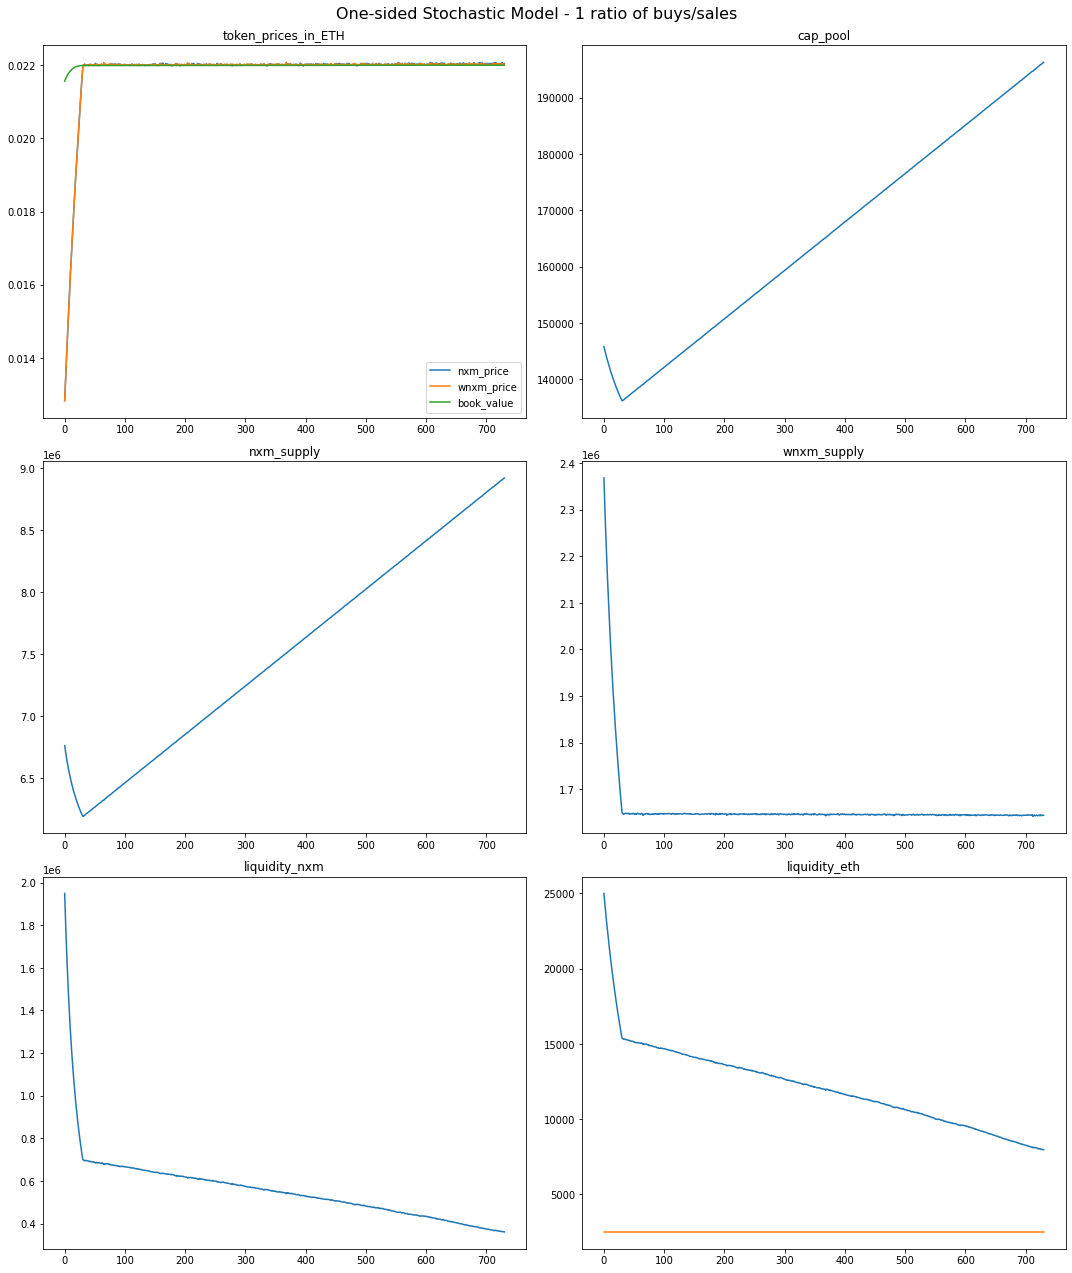

In [22]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(3, 2, figsize=(15,18)) # axs is a (7,2) nd-array

# Subplot
axs[0, 0].plot(range(days_run+1), sim.nxm_price_prediction, label='nxm_price')
axs[0, 0].plot(range(days_run+1), sim.wnxm_price_prediction, label='wnxm_price')
axs[0, 0].plot(range(days_run+1), sim.book_value_prediction, label='book_value')
axs[0, 0].legend()
axs[0, 0].set_title('token_prices_in_ETH')
# Subplot
axs[0, 1].plot(range(days_run+1), sim.cap_pool_prediction)
axs[0, 1].set_title('cap_pool')
# Subplot
axs[1, 0].plot(range(days_run+1), sim.nxm_supply_prediction)
axs[1, 0].set_title('nxm_supply')
# Subplot
axs[1, 1].plot(range(days_run+1), sim.wnxm_supply_prediction)
axs[1, 1].set_title('wnxm_supply')
# Subplot
axs[2, 0].plot(range(days_run+1), sim.liquidity_nxm_prediction)
axs[2, 0].set_title('liquidity_nxm')
# Subplot
axs[2, 1].plot(range(days_run+1), sim.liquidity_eth_prediction)
axs[2, 1].plot(range(days_run+1), np.full(shape=days_run+1, fill_value=target_liq))
axs[2, 1].set_title('liquidity_eth')
# # Subplot
# axs[4, 0].plot(range(days_run+1), sim.nxm_burned_prediction)
# axs[4, 0].set_title('nxm_burned')
# # Subplot
# axs[4, 1].plot(range(days_run+1), sim.nxm_minted_prediction)
# axs[4, 1].set_title('nxm_minted')
# # Subplot
# axs[5, 0].plot(range(days_run+1), sim.eth_sold_prediction)
# axs[5, 0].set_title('eth_sold')
# # Subplot
# axs[5, 1].plot(range(days_run+1), sim.eth_acquired_prediction)
# axs[5, 1].set_title('eth_acquired')
# # Subplot
# axs[6, 0].plot(range(days_run+1), sim.wnxm_removed_prediction)
# axs[6, 0].set_title('wnxm_removed')
# # Subplot
# axs[6, 1].plot(range(days_run+1), sim.wnxm_created_prediction)
# axs[6, 1].set_title('wnxm_created')

fig.suptitle('One-sided Stochastic Model - 1 ratio of buys/sales', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [29]:
print(f'''Closing state:
nxm_price: {sim.nxm_price()}
wnxm_price: {sim.wnxm_price}
book_value: {sim.book_value()}
cap_pool: {sim.cap_pool}
nxm_supply: {sim.nxm_supply}
wnxm_supply: {sim.wnxm_supply}
liquidity_eth: {sim.liquidity_eth}
liquidity_nxm: {sim.liquidity_nxm}
''')

Closing state:
nxm_price: 0.029090955084061527
wnxm_price: 0.029038789919661457
book_value: 0.02303233796035092
cap_pool: 180992.4929473485
nxm_supply: 7858190.221892303
wnxm_supply: 1140037.1786133412
liquidity_eth: 2504.307408743038
liquidity_nxm: 86085.43107321727



In [ ]:
sim.base_daily_platform_buys = np.random.poisson(
                                                lam=lambda_entries,
                                                size=200)
sim.base_daily_platform_sales = np.random.poisson(
                                                lam=lambda_exits,
                                                size=200)

In [ ]:
sim.one_day_passes()

print(f'''Closing state:
nxm_price: {sim.nxm_price()}
wnxm_price: {sim.wnxm_price}
book_value: {sim.book_value()}
cap_pool: {sim.cap_pool}
nxm_supply: {sim.nxm_supply}
wnxm_supply: {sim.wnxm_supply}
liquidity_eth: {sim.liquidity_eth}
liquidity_nxm: {sim.liquidity_nxm}
''')

In [ ]:
round(sim.nxm_price(), 4) < round(sim.book_value(), 4)

In [ ]:
sim.platform_nxm_buy(n_nxm=sim.nxm_sale_size())

### Multi-sim set-ups

#### Global Parameters

In [ ]:
# model days
model_days = 730

# wnxm move size per 1 ETH
wnxm_move_size = fixed_wnxm_move_size
# opening wnxm price
wnxm_open_price = sys_params.wnxm_price_now

# opening liquidity
open_liq = 25_000
#target liquidity
target_liq = 2500

# percentage of target per day that liquidity moves (additively) towards target
liq_move_perc = 0.04
# number of daily liquidity moves
liq_moves_per_day = 10

# ratchet speed
ratchet_bv_perc = 0.04
# number of ratchets per day
ratchets_per_day = 10

# number of entries & exits per day
lambda_entries = 100
lambda_exits = 100

# lognormal dist of size of entries and exits
entry_shape = 1.7
entry_loc = 0
entry_scale = 1
exit_shape = 1.7
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 4.3

#### One-sided Stochastic Model

In [ ]:
# number of simulations & initialise list of instances
num_sims = 100
sims = [UniOneStoch(open_liq=open_liq, target_liq=target_liq) for x in range(num_sims)]

# loop through individual instances and number of days for each simulation
for sim in tqdm(sims):
    for i in range(model_days):
        sim.one_day_passes()
        
 #-----RESULT VISUALISATION-----#
# Final outcome arrays
final_cap_pool_list = [sim.cap_pool_prediction[-1] for sim in sims]
final_book_value_list = [sim.book_value_prediction[-1] for sim in sims]
final_nxm_price_list = [sim.nxm_price_prediction[-1] for sim in sims]
final_wnxm_price_list = [sim.wnxm_price_prediction[-1] for sim in sims]
final_nxm_supply_list = [sim.nxm_supply_prediction[-1] for sim in sims]
final_wnxm_supply_list = [sim.wnxm_supply_prediction[-1] for sim in sims]
final_liquidity_nxm_list = [sim.liquidity_nxm_prediction[-1] for sim in sims]
final_liquidity_eth_list = [sim.liquidity_eth_prediction[-1] for sim in sims]
final_eth_sold_list = [sim.eth_sold_prediction[-1] for sim in sims]
final_eth_acquired_list = [sim.eth_acquired_prediction[-1] for sim in sims]
final_nxm_burned_list = [sim.nxm_burned_prediction[-1] for sim in sims]
final_nxm_minted_list = [sim.nxm_minted_prediction[-1] for sim in sims]
final_wnxm_removed_list = [sim.wnxm_removed_prediction[-1] for sim in sims]
final_wnxm_created_list = [sim.wnxm_created_prediction[-1] for sim in sims]

In [ ]:
#-----HISTOGRAMS-----#
# Destructuring initialization
fig, axs = plt.subplots(4, 2, figsize=(15,18)) # axs is a (7,2) nd-array

# Subplot
axs[0, 0].hist(final_cap_pool_list, bins=20)
axs[0, 0].set_title('cap_pool')
# Subplot
axs[0, 1].hist(final_book_value_list, bins=20)
axs[0, 1].set_title('book_value')
# Subplot
axs[1, 0].hist(final_nxm_price_list, bins=20)
axs[1, 0].set_title('nxm_price')
# Subplot
axs[1, 1].hist(final_wnxm_price_list, bins=20)
axs[1, 1].set_title('wnxm_price')
# Subplot
axs[2, 0].hist(final_nxm_supply_list, bins=20)
axs[2, 0].set_title('nxm_supply')
# Subplot
axs[2, 1].hist(final_wnxm_supply_list, bins=20)
axs[2, 1].set_title('wnxm_supply')
# Subplot
axs[3, 0].hist(final_liquidity_nxm_list, bins=20)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].hist(final_liquidity_eth_list, bins=20)
axs[3, 1].set_title('liquidity_eth')
# # Subplot
# axs[4, 0].hist(final_eth_sold_list, bins=20)
# axs[4, 0].set_title('eth_sold')
# # Subplot
# axs[4, 1].hist(final_eth_acquired_list, bins=20)
# axs[4, 1].set_title('eth_acquired')
# # Subplot
# axs[5, 0].hist(final_nxm_burned_list, bins=20)
# axs[5, 0].set_title('nxm_burned')
# # Subplot
# axs[5, 1].hist(final_nxm_minted_list, bins=20)
# axs[5, 1].set_title('nxm_minted')
# # Subplot
# axs[6, 0].hist(final_wnxm_removed_list, bins=20)
# axs[6, 0].set_title('wnxm_removed')
# # Subplot
# axs[6, 1].hist(final_wnxm_created_list, bins=20)
# axs[6, 1].set_title('wnxm_created')

fig.suptitle('One-sided Stochastic Model - 1.2 buys/sales', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### One-sided Deterministic Model

In [ ]:
# number of simulations & initialise list of instances
num_sims = 100
sims = [UniOneDet(open_liq=open_liq, target_liq=target_liq) for x in range(num_sims)]

# loop through individual instances and number of days for each simulation
for sim in tqdm(sims):
    for i in range(model_days):
        sim.one_day_passes()
        
 #-----RESULT VISUALISATION-----#
# Final outcome arrays
final_cap_pool_list = [sim.cap_pool_prediction[-1] for sim in sims]
final_book_value_list = [sim.book_value_prediction[-1] for sim in sims]
final_nxm_price_list = [sim.nxm_price_prediction[-1] for sim in sims]
final_wnxm_price_list = [sim.wnxm_price_prediction[-1] for sim in sims]
final_nxm_supply_list = [sim.nxm_supply_prediction[-1] for sim in sims]
final_wnxm_supply_list = [sim.wnxm_supply_prediction[-1] for sim in sims]
final_liquidity_nxm_list = [sim.liquidity_nxm_prediction[-1] for sim in sims]
final_liquidity_eth_list = [sim.liquidity_eth_prediction[-1] for sim in sims]
final_eth_sold_list = [sim.eth_sold_prediction[-1] for sim in sims]
final_eth_acquired_list = [sim.eth_acquired_prediction[-1] for sim in sims]
final_nxm_burned_list = [sim.nxm_burned_prediction[-1] for sim in sims]
final_nxm_minted_list = [sim.nxm_minted_prediction[-1] for sim in sims]
final_wnxm_removed_list = [sim.wnxm_removed_prediction[-1] for sim in sims]
final_wnxm_created_list = [sim.wnxm_created_prediction[-1] for sim in sims]

#-----HISTOGRAMS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array

# Subplot
axs[0, 0].hist(final_cap_pool_list, bins=20)
axs[0, 0].set_title('cap_pool')
# Subplot
axs[0, 1].hist(final_book_value_list, bins=20)
axs[0, 1].set_title('book_value')
# Subplot
axs[1, 0].hist(final_nxm_price_list, bins=20)
axs[1, 0].set_title('nxm_price')
# Subplot
axs[1, 1].hist(final_wnxm_price_list, bins=20)
axs[1, 1].set_title('wnxm_price')
# Subplot
axs[2, 0].hist(final_nxm_supply_list, bins=20)
axs[2, 0].set_title('nxm_supply')
# Subplot
axs[2, 1].hist(final_wnxm_supply_list, bins=20)
axs[2, 1].set_title('wnxm_supply')
# Subplot
axs[3, 0].hist(final_liquidity_nxm_list, bins=20)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].hist(final_liquidity_eth_list, bins=20)
axs[3, 1].set_title('liquidity_eth')
# Subplot
axs[4, 0].hist(final_eth_sold_list, bins=20)
axs[4, 0].set_title('eth_sold')
# Subplot
axs[4, 1].hist(final_eth_acquired_list, bins=20)
axs[4, 1].set_title('eth_acquired')
# Subplot
axs[5, 0].hist(final_nxm_burned_list, bins=20)
axs[5, 0].set_title('nxm_burned')
# Subplot
axs[5, 1].hist(final_nxm_minted_list, bins=20)
axs[5, 1].set_title('nxm_minted')
# Subplot
axs[6, 0].hist(final_wnxm_removed_list, bins=20)
axs[6, 0].set_title('wnxm_removed')
# Subplot
axs[6, 1].hist(final_wnxm_created_list, bins=20)
axs[6, 1].set_title('wnxm_created')

plt.show()

### Testing Ratchet Speed and Liquidity for different drain speeds

This section aims to investigate how quickly we can the capital pool drains in worst-case scenarios depending on different parameter rates.

Parameters that can be investigated:
- sell pressure vs buy pressure
- drops in wNXM value
- ratchet speed up
- liquidity provision speed
- liquidity target
- initial liquidity provision

#### Sell Pressure levels

In [31]:
# model days
model_days = 730

# opening liquidity
open_liq = 25_000
#target liquidity
target_liq = 2500

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = fixed_wnxm_move_size
# opening wnxm price - SET TO BOOK VALUE TO MAXIMISE DRAIN
wnxm_open_price = system_instance.book_value()

# number of entries & exits per day
lambda_entries = 100
# EXITS TO BE TESTED

# lognormal dist of size of entries and exits
entry_shape = 1.7
entry_loc = 0
entry_scale = 1
exit_shape = 1.7
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 4.3

# range of variables to test
lambda_exits_range = [100, 110, 120, 140, 160, 180, 200]

# create sims and names
sims = []

for i in lambda_exits_range:
    lambda_exits = i
    sims.append(UniOneDet(open_liq=open_liq, target_liq=target_liq))
    
for sim in sims:
    days_run = 0
    for i in tqdm(range(model_days)):
        try:
            sim.one_day_passes()
            days_run += 1
        except ZeroDivisionError:
            print('Something went to Zero!')
            break

 62%|█████████████████████████████████████████████████▊                              | 455/730 [00:00<00:00, 648.64it/s]

Day 365 - ratchet - pre arbitrage: nxm_price = 0.021530685834879847, wnxm_price = 0.021529471440139707
                                            book_value = 0.02153065414011538, cap_pool = 177206.09121209203,
                                            nxm_supply = 8230409.0743776355, wnxm_supply = 2793363.6456795232
                
Day 365 - ratchet - pre event: nxm_price = 0.021530685834879847, wnxm_price = 0.021529471440139707
                                            book_value = 0.02153065414011538, cap_pool = 177206.09121209203,
                                            nxm_supply = 8230409.0743776355, wnxm_supply = 2793363.6456795232
                
Day 365 - ratchet - post event: nxm_price = 0.02153065414011538, wnxm_price = 0.021529471440139707
                                                book_value = 0.02153065414011538, cap_pool = 177206.09121209203,
                                                nxm_supply = 8230409.0743776355, wnxm_supply = 2793363.6456795232


 56%|████████████████████████████████████████████▉                                   | 410/730 [00:00<00:00, 610.23it/s]

Day 365 - platform_sale - pre arbitrage: nxm_price = 0.02154703018760563, wnxm_price = 0.021546937631233026
                                            book_value = 0.021530665700247392, cap_pool = 177171.48471667615,
                                            nxm_supply = 8228797.343439335, wnxm_supply = 2791743.63145764
                
Day 365 - platform_sale - pre event: nxm_price = 0.02154703018760563, wnxm_price = 0.021546937631233026
                                            book_value = 0.021530665700247392, cap_pool = 177171.48471667615,
                                            nxm_supply = 8228797.343439335, wnxm_supply = 2791743.63145764
                
Day 365 - platform_sale - post event: nxm_price = 0.0215388547269303, wnxm_price = 0.021546937631233026
                                                book_value = 0.021530665402515647, cap_pool = 177167.18553251517,
                                                nxm_supply = 8228597.779974553, wnxm_supply = 2791743.

 56%|████████████████████████████████████████████▊                                   | 409/730 [00:00<00:00, 627.18it/s]

Day 365 - platform_buy - pre arbitrage: nxm_price = 0.021530788510372992, wnxm_price = 0.021538433572097015
                                            book_value = 0.02153077165803053, cap_pool = 177187.93219599326,
                                            nxm_supply = 8229520.75337745, wnxm_supply = 2792531.173112074
                
Day 365 - platform_buy - pre event: nxm_price = 0.021539029233406976, wnxm_price = 0.021536282808684068
                                            book_value = 0.021530771758420435, cap_pool = 177192.23301880845,
                                            nxm_supply = 8229720.467382254, wnxm_supply = 2792730.8871168783
                
Day 365 - platform_buy - post event: nxm_price = 0.021539029233406976, wnxm_price = 0.021538432534539253
                                                book_value = 0.021530771758420435, cap_pool = 177192.23301880845,
                                                nxm_supply = 8229720.467382254, wnxm_supply = 279253

 67%|█████████████████████████████████████████████████████▌                          | 489/730 [00:00<00:00, 686.40it/s]

Day 365 - platform_sale - pre arbitrage: nxm_price = 0.0215389770450369, wnxm_price = 0.021538039260208336
                                            book_value = 0.021530654489746125, cap_pool = 177189.3539952193,
                                            nxm_supply = 8229631.573884803, wnxm_supply = 2792566.4702920965
                
Day 365 - platform_sale - pre event: nxm_price = 0.0215389770450369, wnxm_price = 0.021538039260208336
                                            book_value = 0.021530654489746125, cap_pool = 177189.3539952193,
                                            nxm_supply = 8229631.573884803, wnxm_supply = 2792566.4702920965
                
Day 365 - platform_sale - post event: nxm_price = 0.021530734773237647, wnxm_price = 0.021538039260208336
                                                book_value = 0.02153065438783331, cap_pool = 177185.05481803368,
                                                nxm_supply = 8229431.935805844, wnxm_supply = 2792566

 68%|██████████████████████████████████████████████████████                          | 493/730 [00:00<00:00, 676.94it/s]

Day 365 - platform_sale - pre arbitrage: nxm_price = 0.021538916515076535, wnxm_price = 0.02154273749863111
                                            book_value = 0.021530704261128072, cap_pool = 177179.9374221738,
                                            nxm_supply = 8229175.194332018, wnxm_supply = 2792132.154071945
                
Day 365 - platform_sale - pre event: nxm_price = 0.021547123093441742, wnxm_price = 0.02154058711722313
                                            book_value = 0.0215307045598847, cap_pool = 177184.23824127085,
                                            nxm_supply = 8229374.832972011, wnxm_supply = 2792331.7927119387
                
Day 365 - platform_sale - post event: nxm_price = 0.021538919639795154, wnxm_price = 0.02154058711722313
                                                book_value = 0.021530704261203966, cap_pool = 177179.93905990006,
                                                nxm_supply = 8229175.270367697, wnxm_supply = 2792331

 68%|██████████████████████████████████████████████████████▋                         | 499/730 [00:00<00:00, 676.31it/s]

Day 365 - platform_buy - pre arbitrage: nxm_price = 0.02152276582175782, wnxm_price = 0.021529948074760878
                                            book_value = 0.02153077655100001, cap_pool = 177205.19595455014,
                                            nxm_supply = 8230320.700918691, wnxm_supply = 2793323.5409255703
                
Day 365 - platform_buy - pre event: nxm_price = 0.02152276582175782, wnxm_price = 0.021529948074760878
                                            book_value = 0.02153077655100001, cap_pool = 177205.19595455014,
                                            nxm_supply = 8230320.700918691, wnxm_supply = 2793323.5409255703
                
Day 365 - platform_buy - post event: nxm_price = 0.02153082160932725, wnxm_price = 0.021529948074760878
                                                book_value = 0.021530776454311132, cap_pool = 177209.49675920152,
                                                nxm_supply = 8230520.489367612, wnxm_supply = 2793323.

 68%|██████████████████████████████████████████████████████                          | 493/730 [00:00<00:00, 652.94it/s]

Day 365 - platform_sale - pre arbitrage: nxm_price = 0.021547182263764536, wnxm_price = 0.02154681185334014
                                            book_value = 0.02153064996259811, cap_pool = 177171.7808016088,
                                            nxm_supply = 8228817.109998171, wnxm_supply = 2791754.1480425615
                
Day 365 - platform_sale - pre event: nxm_price = 0.021547182263764536, wnxm_price = 0.02154681185334014
                                            book_value = 0.02153064996259811, cap_pool = 177171.7808016088,
                                            nxm_supply = 8228817.109998171, wnxm_supply = 2791754.1480425615
                
Day 365 - platform_sale - post event: nxm_price = 0.02153893407262792, wnxm_price = 0.02154681185334014
                                                book_value = 0.02153064966168143, cap_pool = 177167.48162470057,
                                                nxm_supply = 8228617.547941873, wnxm_supply = 2791754.1

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 666.74it/s]


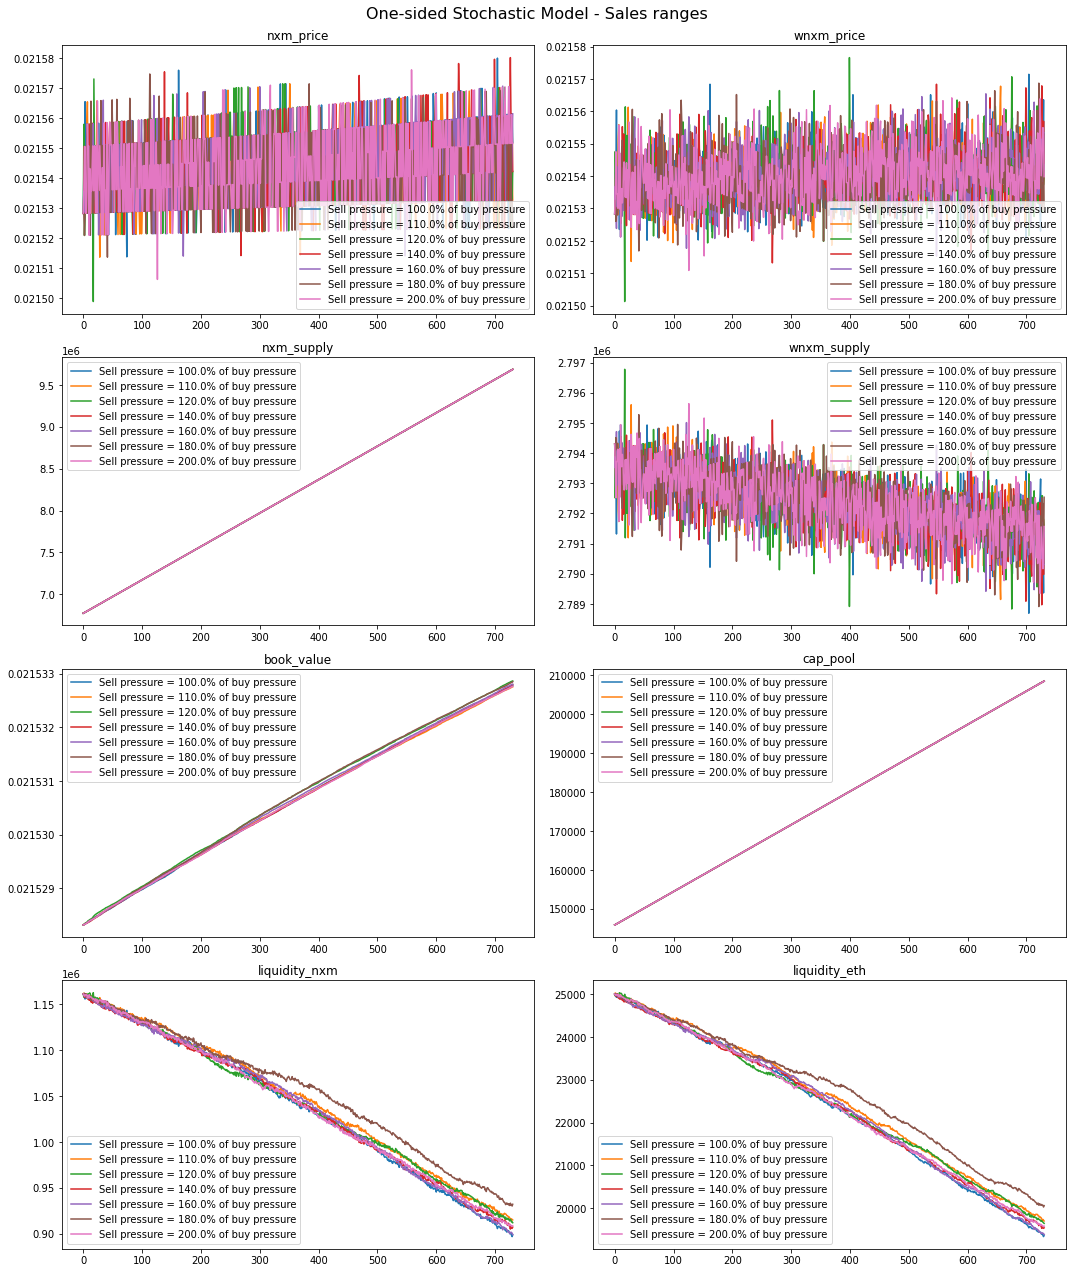

In [32]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(4, 2, figsize=(15,18)) # axs is a (6,2) nd-array
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(days_run+1), sims[i].nxm_price_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(days_run+1), sims[i].wnxm_price_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(days_run+1), sims[i].nxm_supply_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(days_run+1), sims[i].wnxm_supply_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(days_run+1), sims[i].book_value_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(days_run+1), sims[i].cap_pool_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(days_run+1), sims[i].liquidity_nxm_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(days_run+1), sims[i].liquidity_eth_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
# for i in range(len(sims)):
#     axs[4, 0].plot(range(days_run+1), sims[i].nxm_burned_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
# axs[4, 0].set_title('nxm_burned')
# axs[4, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[4, 1].plot(range(days_run+1), sims[i].nxm_minted_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
# axs[4, 1].set_title('nxm_minted')
# axs[4, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 0].plot(range(days_run+1), sims[i].eth_sold_prediction, label=f'Sells = {lambda_exits_range[i]*100/lambda_entries}% of buys')
# axs[5, 0].set_title('eth_sold')
# axs[5, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 1].plot(range(days_run+1), sims[i].eth_acquired_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
# axs[5, 1].set_title('eth_acquired')
# axs[5, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 0].plot(range(days_run+1), sims[i].wnxm_removed_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
# axs[6, 0].set_title('wnxm_removed')
# axs[6, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 1].plot(range(days_run+1), sims[i].wnxm_created_prediction, label=f'Sell pressure = {lambda_exits_range[i]*100/lambda_entries}% of buy pressure')
# axs[6, 1].set_title('wnxm_created')
# axs[6, 1].legend()

fig.suptitle('One-sided Stochastic Model - Sales ranges', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### Opening wNXM value

In [ ]:
# model days
model_days = 730

# opening liquidity
open_liq = 25_000
#target liquidity
target_liq = 2500

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = fixed_wnxm_move_size
# opening wnxm price TO BE TESTED

# number of entries & exits per day
lambda_entries = 120
lambda_exits = 100

# lognormal dist of size of entries and exits
entry_shape = 1.7
entry_loc = 0
entry_scale = 1
exit_shape = 1.7
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 4.3

# range of variables to test
wnxm_open_price_range = [0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.03]

# create sims
sims = []

for i in wnxm_open_price_range:
    wnxm_open_price = i
    sims.append(UniOneStoch(open_liq=open_liq, target_liq=target_liq))
    
for sim in sims:
    days_run = 0
    for i in tqdm(range(model_days)):
        try:
            sim.one_day_passes()
            days_run += 1
        except ZeroDivisionError:
            print('Something went to Zero!')
            break

In [ ]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(4, 2, figsize=(15,18))
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(days_run+1), sims[i].nxm_price_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(days_run+1), sims[i].wnxm_price_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(days_run+1), sims[i].nxm_supply_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(days_run+1), sims[i].wnxm_supply_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(days_run+1), sims[i].book_value_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(days_run+1), sims[i].cap_pool_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(days_run+1), sims[i].liquidity_nxm_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(days_run+1), sims[i].liquidity_eth_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
# for i in range(len(sims)):
#     axs[4, 0].plot(range(days_run+1), sims[i].nxm_burned_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[4, 0].set_title('nxm_burned')
# axs[4, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[4, 1].plot(range(days_run+1), sims[i].nxm_minted_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[4, 1].set_title('nxm_minted')
# axs[4, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 0].plot(range(days_run+1), sims[i].eth_sold_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[5, 0].set_title('eth_sold')
# axs[5, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 1].plot(range(days_run+1), sims[i].eth_acquired_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[5, 1].set_title('eth_acquired')
# axs[5, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 0].plot(range(days_run+1), sims[i].wnxm_removed_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[6, 0].set_title('wnxm_removed')
# axs[6, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 1].plot(range(days_run+1), sims[i].wnxm_created_prediction, label=f'wNXM opening price = {wnxm_open_price_range[i]}')
# axs[6, 1].set_title('wnxm_created')
# axs[6, 1].legend()

fig.suptitle('One-sided Stochastic Model - opening wNXM price ranges', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### Ratchet Speeds

In [ ]:
# model days
model_days = 730

# opening liquidity
open_liq = 25_000
#target liquidity
target_liq = 2500

# amount of USD it takes to make a 2% change in NXM price
wnxm_move_size = fixed_wnxm_move_size
# opening wnxm price TO BE TESTED
wnxm_open_price = sys_params.wnxm_price_now

# number of entries & exits per day
lambda_entries = 110
lambda_exits = 100

# lognormal dist of size of entries and exits
entry_shape = 1.7
entry_loc = 0
entry_scale = 1
exit_shape = 1.7
exit_loc = 0
exit_scale = 1

# deterministic entry & exit size
det_sell_size = 4.3

# range of variables to test
ratchet_range = [0.01, 0.025, 0.04, 0.06, 0.08, 0.1, 0.2]

# create sims
sims = []

for i in ratchet_range:
    ratchet_bv_perc = i
    sims.append(UniOneStoch(open_liq=open_liq, target_liq=target_liq))
    
for sim in sims:
    days_run = 0
    for i in tqdm(range(model_days)):
        try:
            sim.one_day_passes()
            days_run += 1
        except ZeroDivisionError:
            print('Something went to Zero!')
            break

In [ ]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(4, 2, figsize=(15,18))
# Subplot
for i in range(len(sims)):
    axs[0, 0].plot(range(days_run+1), sims[i].nxm_price_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[0, 0].set_title('nxm_price')
axs[0, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[0, 1].plot(range(days_run+1), sims[i].wnxm_price_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[0, 1].set_title('wnxm_price')
axs[0, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 0].plot(range(days_run+1), sims[i].nxm_supply_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[1, 0].set_title('nxm_supply')
axs[1, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[1, 1].plot(range(days_run+1), sims[i].wnxm_supply_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[1, 1].set_title('wnxm_supply')
axs[1, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 0].plot(range(days_run+1), sims[i].book_value_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[2, 0].set_title('book_value')
axs[2, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[2, 1].plot(range(days_run+1), sims[i].cap_pool_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[2, 1].set_title('cap_pool')
axs[2, 1].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 0].plot(range(days_run+1), sims[i].liquidity_nxm_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[3, 0].set_title('liquidity_nxm')
axs[3, 0].legend()
# Subplot
for i in range(len(sims)):
    axs[3, 1].plot(range(days_run+1), sims[i].liquidity_eth_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
axs[3, 1].set_title('liquidity_eth')
axs[3, 1].legend()
# Subplot
# for i in range(len(sims)):
#     axs[4, 0].plot(range(days_run+1), sims[i].nxm_burned_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[4, 0].set_title('nxm_burned')
# axs[4, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[4, 1].plot(range(days_run+1), sims[i].nxm_minted_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[4, 1].set_title('nxm_minted')
# axs[4, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 0].plot(range(days_run+1), sims[i].eth_sold_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[5, 0].set_title('eth_sold')
# axs[5, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[5, 1].plot(range(days_run+1), sims[i].eth_acquired_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[5, 1].set_title('eth_acquired')
# axs[5, 1].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 0].plot(range(days_run+1), sims[i].wnxm_removed_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[6, 0].set_title('wnxm_removed')
# axs[6, 0].legend()
# # Subplot
# for i in range(len(sims)):
#     axs[6, 1].plot(range(days_run+1), sims[i].wnxm_created_prediction, label=f'ratchet speed = {ratchet_range[i]*100}% of BV/day')
# axs[6, 1].set_title('wnxm_created')
# axs[6, 1].legend()

fig.suptitle('One-sided Stochastic Model - opening wNXM price ranges', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()